# In this notebook, my goal is to study how cholesterol affect our chances of getting a heart disease.

In [34]:
import pandas as pd
df = pd.read_csv("/home/yair/Documents/Bar-Ilan/third-year/semester2/Statistical-Theory/heart_disease_dataset.csv")
df.head()

,Age,Gender,Cholesterol,Blood Pressure,Heart Rate,Smoking,Alcohol Intake,Exercise Hours,Family History,Diabetes,Obesity,Stress Level,Blood Sugar,Exercise Induced Angina,Chest Pain Type,Heart Disease
0,75,Female,228,119,66,Current,Heavy,1,No,No,Yes,8,119,Yes,Atypical Angina,1
1,48,Male,204,165,62,Current,Nothing,5,No,No,No,9,70,Yes,Typical Angina,0
2,53,Male,234,91,67,Never,Heavy,3,Yes,No,Yes,5,196,Yes,Atypical Angina,1
3,69,Female,192,90,72,Current,Nothing,4,No,Yes,No,7,107,Yes,Non-anginal Pain,0
4,62,Female,172,163,93,Never,Nothing,6,No,Yes,No,2,183,Yes,Asymptomatic,0


## Let's start by looking at how the data distribute.

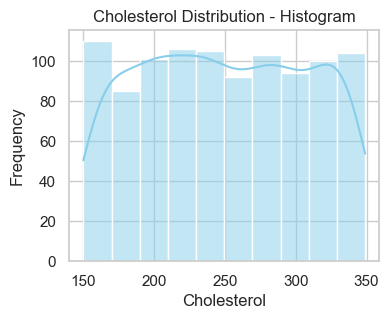

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set the style of the plot
sns.set(style="whitegrid")

# Plot histogram of the Age feature
plt.figure(figsize=(4, 3))
sns.histplot(df['Cholesterol'], bins=10, kde=True, color='skyblue')
plt.title('Cholesterol Distribution - Histogram')
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')

# Display the plot
plt.show()


### Let's look at the mean and the max for people who don't have heart disease vs people who do:

In [36]:
# Separate data by heart disease status
heart_disease_positive = df[df['Heart Disease'] == 1]
heart_disease_negative = df[df['Heart Disease'] == 0]

# Calculate min and max for Age and Cholesterol for both groups
# For those with heart disease
Cholesterol_min_hd = heart_disease_positive['Cholesterol'].min()
Cholesterol_max_hd = heart_disease_positive['Cholesterol'].max()


# For those without heart disease
Cholesterol_min_no_hd = heart_disease_negative['Cholesterol'].min()
Cholesterol_max_no_hd = heart_disease_negative['Cholesterol'].max()


print("For people with heart disease:")
print(f"Cholesterol - Min: {Cholesterol_min_hd}, Max: {Cholesterol_max_hd}")

print("\nFor people without heart disease:")
print(f"Cholesterol - Min: {Cholesterol_min_no_hd}, Max: {Cholesterol_max_no_hd}")

For people with heart disease:
Cholesterol - Min: 201, Max: 349

For people without heart disease:
Cholesterol - Min: 150, Max: 349


### Let's do a plot box

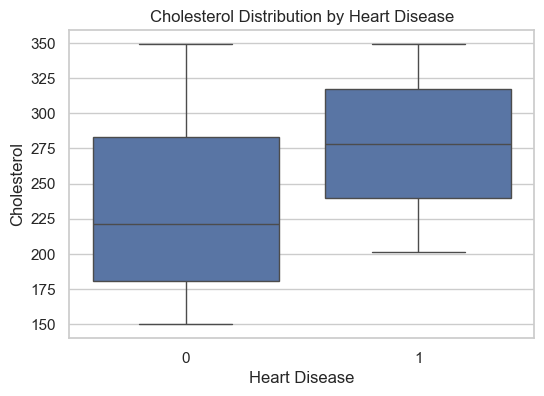

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(x='Heart Disease', y='Cholesterol', data=df)
plt.title('Cholesterol Distribution by Heart Disease')
plt.show()

### And a voilen plot:

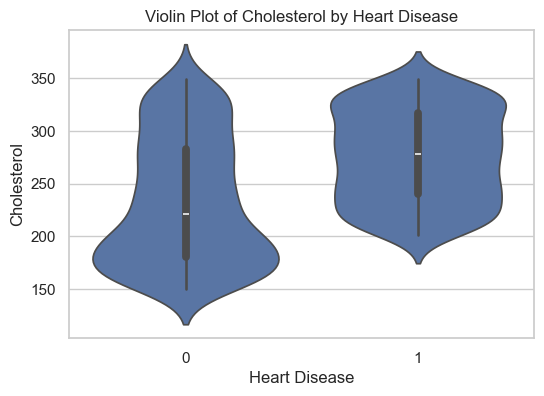

In [38]:
plt.figure(figsize=(6, 4))
sns.violinplot(x='Heart Disease', y='Cholesterol', data=df)
plt.title('Violin Plot of Cholesterol by Heart Disease')
plt.show()

## We can use logistic regression to try and find a "turning point" for when you chances of heart disease increase.

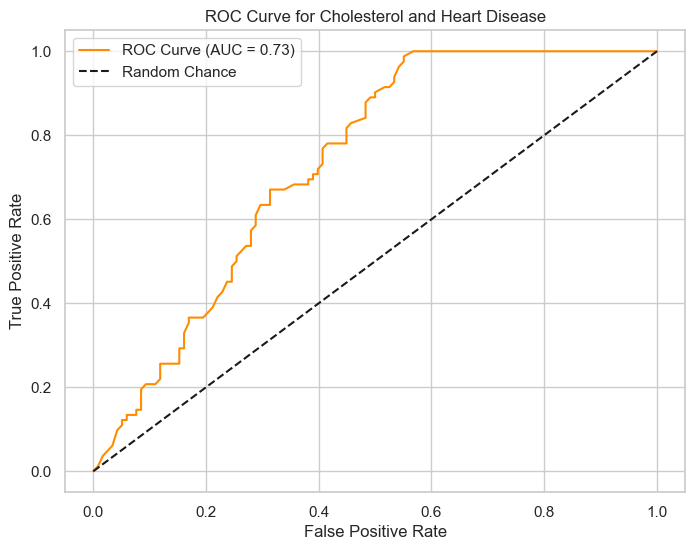

Optimal threshold for Cholesterol: 0.24053683697030065


In [39]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# Step 1: Prepare the data
# Assuming your dataset is in a DataFrame called 'df' and you have 'Cholesterol' and 'HeartDisease' columns
X = df[['Cholesterol']]  # Feature: Cholesterol
y = df['Heart Disease']    # Target: Heart Disease (0 or 1)

# Step 2: Train-test split (optional, but good practice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Step 4: Predict probabilities of heart disease based on cholesterol levels
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of heart disease (class 1)

# Step 5: Plot ROC curve to assess model performance
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curve for Cholesterol and Heart Disease')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Step 6: Find the threshold that maximizes the true positive rate while minimizing false positives
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold for Cholesterol: {optimal_threshold}")


### and for the cholesterol itself:

In [40]:
# Extract model coefficients (beta_0 is intercept, beta_1 is coefficient for Cholesterol)
beta_0 = log_reg.intercept_[0]  # Intercept
beta_1 = log_reg.coef_[0][0]    # Coefficient for Cholesterol

# Threshold probability (from ROC)
threshold_prob = 0.2405

# Calculate the cholesterol level that gives this probability
cholesterol_threshold = (np.log(threshold_prob / (1 - threshold_prob)) - beta_0) / beta_1
print(f"Cholesterol level corresponding to the probability threshold: {cholesterol_threshold:.2f} mg/dL")


Cholesterol level corresponding to the probability threshold: 204.99 mg/dL


### Let's test our result statistically using two-porpotion z test.

In [52]:
from statsmodels.stats.proportion import proportions_ztest

# Step 1: Define a threshold (e.g., 200 mg/dL)
threshold = 205

# Step 2: Create two groups based on the cholesterol threshold
group_below_threshold = df[df['Cholesterol'] < threshold]
group_above_threshold = df[df['Cholesterol'] >= threshold]

# Step 3: Get the number of heart disease cases and total observations in both groups
heart_disease_below = group_below_threshold['Heart Disease'].sum()  # Cases of heart disease (1)
n1 = group_below_threshold.shape[0]  # Total number of people in the group below threshold

heart_disease_above = group_above_threshold['Heart Disease'].sum()  # Cases of heart disease (1)
n2 = group_above_threshold.shape[0]  # Total number of people in the group above threshold

# Step 4: Perform two-proportion z-test
count = np.array([heart_disease_below, heart_disease_above])
nobs = np.array([n1, n2])
stat, pval = proportions_ztest(count, nobs)

# Step 5: Output the test statistic and p-value
print(f"Two-proportion z-test statistic: {stat}, p-value: {pval}")

# Interpretation of p-value
if pval < 0.05:
    print(f"There is a significant difference in heart disease cases between the two groups (p = {pval:.3f}).")
else:
    print(f"There is no significant difference in heart disease cases between the two groups (p = {pval:.3f}).")


Two-proportion z-test statistic: -14.356138776689361, p-value: 9.751055546936553e-47
There is a significant difference in heart disease cases between the two groups (p = 0.000).


### And we did found out that there is a significant differnce from cholestorl above 205 mg to below it. meaning we should aim to keep out cholesterol lower than that.

### Let's search for another "turning point" where the chance for heart disease rises, just for cholesterol highter than 205 in jumps of 10.

In [53]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Data filtering
df_high_cholesterol = df[df['Cholesterol'] > 205]  # Data for cholesterol > 205

# Set up a range of thresholds (e.g., every 10 mg/dL)
cholesterol_thresholds = np.arange(210, df_high_cholesterol['Cholesterol'].max(), 10)

# Initialize variables to store the best threshold
best_pval = 1  # Initialize to 1 (highest p-value)
best_threshold = None

# Iterate over possible thresholds and perform two-proportion z-test
for threshold in cholesterol_thresholds:
    # Split data into two groups based on the current threshold
    group_below = df_high_cholesterol[df_high_cholesterol['Cholesterol'] <= threshold]
    group_above = df_high_cholesterol[df_high_cholesterol['Cholesterol'] > threshold]

    # Count the number of heart disease cases in each group
    heart_disease_below = group_below['Heart Disease'].sum()
    heart_disease_above = group_above['Heart Disease'].sum()

    # Total number of observations in each group
    n_below = group_below.shape[0]
    n_above = group_above.shape[0]

    # Perform two-proportion z-test
    count = np.array([heart_disease_below, heart_disease_above])
    nobs = np.array([n_below, n_above])
    stat, pval = proportions_ztest(count, nobs)

    # Keep track of the threshold with the lowest p-value
    if pval < best_pval:
        best_pval = pval
        best_threshold = threshold

# Output the best threshold and p-value
print(f"Best turning point (Cholesterol): {best_threshold} mg/dL, p-value: {best_pval}")


Best turning point (Cholesterol): 240 mg/dL, p-value: 0.18980114824253358


### We did get some kind of a turning point, but our p-value is high, meaning that probably from 205 and above we don't have another change.

### Just to be sure, since our data of cholesterol isn't normal Let's run another Polynomial Logistic Regression.

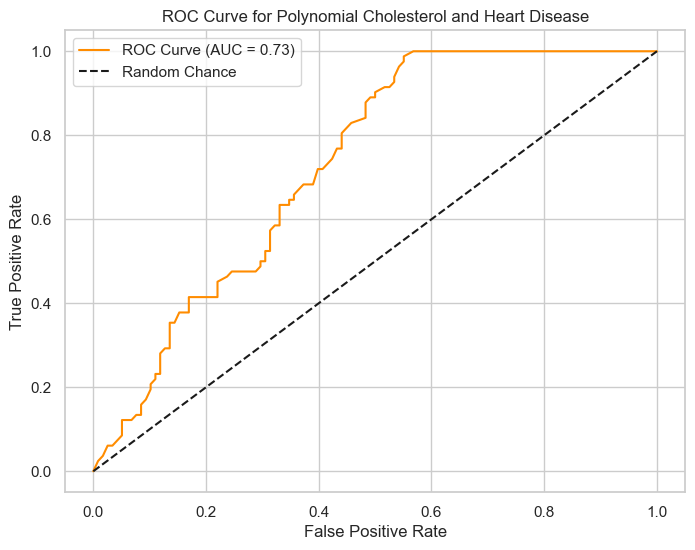

Intercept: [-21.01400038]
Coefficients for Cholesterol and Cholesterol^2: [[ 5.20625176e-10  1.49771403e-01 -2.60685986e-04]]
Optimal threshold for Cholesterol (based on polynomial model): 0.21990994427801552


In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming your dataset is in a DataFrame called 'df' and you have 'Cholesterol' and 'HeartDisease' columns
X = df[['Cholesterol']]  # Feature: Cholesterol
y = df['Heart Disease']   # Target: Heart Disease (0 or 1)

# Step 1: Generate Polynomial Features (degree 2 for quadratic relationship)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Step 2: Train-test split (optional, but good practice)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Step 3: Fit logistic regression model on the polynomial features
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Step 4: Predict probabilities of heart disease based on cholesterol levels
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of heart disease (class 1)

# Step 5: Calculate and plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curve for Polynomial Cholesterol and Heart Disease')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Step 6: Interpret the coefficients of the polynomial model
print("Intercept:", log_reg.intercept_)
print("Coefficients for Cholesterol and Cholesterol^2:", log_reg.coef_)

# Step 7: Find the threshold that maximizes the true positive rate while minimizing false positives
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold for Cholesterol (based on polynomial model): {optimal_threshold}")


In [44]:
cholesterol_test = X_test[:, 1]  # Extract the original Cholesterol values from the polynomial features
optimal_cholesterol = cholesterol_test[np.abs(y_pred_prob - optimal_threshold).argmin()]

# Step 8: Print the results
print(f"Optimal threshold for Cholesterol (based on polynomial model): {optimal_threshold}")
print(f"Cholesterol value corresponding to the optimal threshold: {optimal_cholesterol:.2f} mg/dL")

Optimal threshold for Cholesterol (based on polynomial model): 0.21990994427801552
Cholesterol value corresponding to the optimal threshold: 205.00 mg/dL


### And We got pretty much the same result, which is quite nice.

## We found a way to divide cholesterol into two groups, so we can explore each group with relation to age and smoking.

### We'll start by defining the groups.

In [45]:
import numpy as np
import pandas as pd

# Define cholesterol risk groups based on the threshold of 205 mg/dL
df['Cholesterol_Group'] = np.where(df['Cholesterol'] < 205, 'Low', 'High')

# Display the first few rows to check the new column
print(df[['Cholesterol', 'Cholesterol_Group']].head())


   Cholesterol Cholesterol_Group
0          228              High
1          204               Low
2          234              High
3          192               Low
4          172               Low


### Let's invastige somking across those groups:

In [46]:
from scipy.stats import chi2_contingency

# Crosstab to see how smoking is distributed across cholesterol groups
smoking_crosstab = pd.crosstab(df['Smoking'], df['Cholesterol_Group'])
print("\nCrosstab of Smoking and Cholesterol Groups:")
print(smoking_crosstab)

# Perform a chi-square test to check if smoking is associated with cholesterol groups
chi2, p, _, _ = chi2_contingency(smoking_crosstab)
print(f"\nChi-square test for Smoking vs. Cholesterol Groups:\nChi2 statistic = {chi2:.4f}, p-value = {p:.4f}")



Crosstab of Smoking and Cholesterol Groups:
Cholesterol_Group  High  Low
Smoking                     
Current             244   92
Former              231   95
Never               253   85

Chi-square test for Smoking vs. Cholesterol Groups:
Chi2 statistic = 1.3447, p-value = 0.5105


### We got a high p-value, meaning that there isn't any statistical connection.

### Let's look at age now:

In [47]:
from scipy.stats import ttest_ind

# Split the data into the two cholesterol groups
low_cholesterol_group = df[df['Cholesterol_Group'] == 'Low']
high_cholesterol_group = df[df['Cholesterol_Group'] == 'High']

# Perform a t-test to compare the age between low and high cholesterol groups
t_stat, p_val = ttest_ind(low_cholesterol_group['Age'], high_cholesterol_group['Age'])
print(f"\nT-test for Age vs. Cholesterol Groups:\nT-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")



T-test for Age vs. Cholesterol Groups:
T-statistic = 0.4982, p-value = 0.6184


### And again, it seems like there isn't a connection between age and cholesterol.

# Let's load our second dataset and see if our results of 205 being the "turning point" is still true.

In [48]:
new_df = pd.read_csv("/home/yair/Downloads/Heart_Disease_Prediction.csv")
new_df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


### Let's take a quick look at the voilen plot:

plt.figure(figsize=(6, 4))
sns.violinplot(x='Heart Disease', y='Cholesterol', data=new_df)
plt.title('Violin Plot of Cholesterol by Heart Disease')
plt.show()

### Preprocessing "Heart Disease" to 0 and 1.

In [49]:
new_df['Heart Disease'] = new_df['Heart Disease'].replace({'Presence': 1, 'Absence': 0})

/tmp/ipykernel_10759/825356655.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df['Heart Disease'] = new_df['Heart Disease'].replace({'Presence': 1, 'Absence': 0})


### Running the regression:

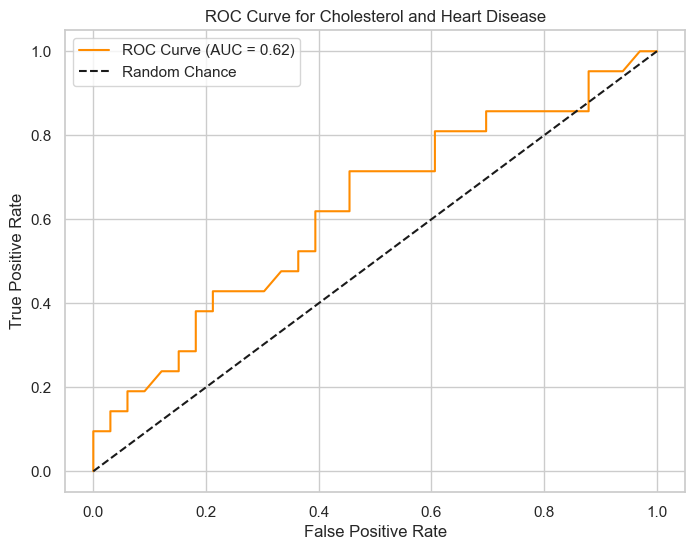

Optimal threshold for Cholesterol: 0.45716259233793183


In [50]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# Step 1: Prepare the data
# Assuming your dataset is in a DataFrame called 'df' and you have 'Cholesterol' and 'HeartDisease' columns
X = new_df[['Cholesterol']]  # Feature: Cholesterol
y = new_df['Heart Disease']    # Target: Heart Disease (0 or 1)

# Step 2: Train-test split (optional, but good practice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Step 4: Predict probabilities of heart disease based on cholesterol levels
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of heart disease (class 1)

# Step 5: Plot ROC curve to assess model performance
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curve for Cholesterol and Heart Disease')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Step 6: Find the threshold that maximizes the true positive rate while minimizing false positives
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold for Cholesterol: {optimal_threshold}")


In [51]:
# Extract model coefficients (beta_0 is intercept, beta_1 is coefficient for Cholesterol)
beta_0 = log_reg.intercept_[0]  # Intercept
beta_1 = log_reg.coef_[0][0]    # Coefficient for Cholesterol

# Threshold probability (from ROC)
threshold_prob = 0.45716259233793183

# Calculate the cholesterol level that gives this probability
cholesterol_threshold = (np.log(threshold_prob / (1 - threshold_prob)) - beta_0) / beta_1
print(f"Cholesterol level corresponding to the probability threshold: {cholesterol_threshold:.2f} mg/dL")


Cholesterol level corresponding to the probability threshold: 249.00 mg/dL


## And we Got a different result from our original 205, but not so far away. Let's check it statistaclly:

In [54]:
from statsmodels.stats.proportion import proportions_ztest

# Step 1: Define a threshold (e.g., 200 mg/dL)
threshold = 249

# Step 2: Create two groups based on the cholesterol threshold
group_below_threshold = df[df['Cholesterol'] < threshold]
group_above_threshold = df[df['Cholesterol'] >= threshold]

# Step 3: Get the number of heart disease cases and total observations in both groups
heart_disease_below = group_below_threshold['Heart Disease'].sum()  # Cases of heart disease (1)
n1 = group_below_threshold.shape[0]  # Total number of people in the group below threshold

heart_disease_above = group_above_threshold['Heart Disease'].sum()  # Cases of heart disease (1)
n2 = group_above_threshold.shape[0]  # Total number of people in the group above threshold

# Step 4: Perform two-proportion z-test
count = np.array([heart_disease_below, heart_disease_above])
nobs = np.array([n1, n2])
stat, pval = proportions_ztest(count, nobs)

# Step 5: Output the test statistic and p-value
print(f"Two-proportion z-test statistic: {stat}, p-value: {pval}")

# Interpretation of p-value
if pval < 0.05:
    print(f"There is a significant difference in heart disease cases between the two groups (p = {pval:.3f}).")
else:
    print(f"There is no significant difference in heart disease cases between the two groups (p = {pval:.3f}).")


Two-proportion z-test statistic: -8.91099242886156, p-value: 5.057777074680336e-19
There is a significant difference in heart disease cases between the two groups (p = 0.000).


### And it does seems like the correct point, since our p-value is low.

# We got our result, so after comparing the two datasets and looking at the result for where it's more likely to get a heart disease, we'll just take the mean as our final answer: 227 mg/dL